<a href="https://colab.research.google.com/github/htsnet/automacao-de-negocios/blob/master/Automacao_de_Negocios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automação de Negócios

Este projeto tem como objetivo a geração de um modelo que permita a automação de decisões de negócios. 

Baseia-se em uma tabela histórica de simulações de aplicações, com dados fornecidos pela Bolsa de Valores de São Paulo.

As operações são de derivativos de contrato de dólar futuro.

Descrição dos campos:

*   CodOp = Código interno da operação (sem significado)
* Hora Entrada = Hora da compra
* Hora Saida = Hora da venda
* Duração = Intervalo de tempo entre saída e entrada
* Data = Data da operação
* Pentrada = Preço do papel no momento da compra
* Psaida = Preço do papel no momento da venda
* Ganhos = Diferença entre compra e venda, se >= 0
* Perdas = Diferença entre compra e venda, se < 0
* --> Resultado = Resultado da operação (1 = ganho, 2 = perda)  <-- campo target
* Ganho Trade = 
* K entra = 
* K Saida =
* Item 1 = classificador número 1
* Item 2 = classificador número 2
* ...
* Item 77 = classificador número 77

Obs. Todos os classificadores são numéricos e sem valores nulos



## Arquivo
É preciso carregar um arquivo CSV com o padrão definido para execução do notebook

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


In [2]:
#carrega a tabela de dados
#separador de campos = ;
#ponto decimal = ,
#historic = pd.read_csv("/content/Amostra Reduzida - Mercado Futuro.csv", sep=";", decimal=",")
historic = pd.read_csv("/content/Amostra Completa - Mercado Futuro.csv", sep=";", decimal=",")


In [3]:
#mostra os primeiros registros
historic.head()

,CodOp,Hora Entrada,Hora Saida,Duração,Data,Pentrada,Psaida,Ganhos,Perdas,Resultado,Saldo Trade,K entra,K Saida,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6,Item 7,Item 8,Item 9,Item 10,Item 11,Item 12,Item 13,Item 14,Item 15,Item 16,Item 17,Item 18,Item 19,Item 20,Item 21,Item 22,Item 23,Item 24,Item 25,Item 26,Item 27,...,Item 38,Item 39,Item 40,Item 41,Item 42,Item 43,Item 44,Item 45,Item 46,Item 47,Item 48,Item 49,Item 50,Item 51,Item 52,Item 53,Item 54,Item 55,Item 56,Item 57,Item 58,Item 59,Item 60,Item 61,Item 62,Item 63,Item 64,Item 65,Item 66,Item 67,Item 68,Item 69,Item 70,Item 71,Item 72,Item 73,Item 74,Item 75,Item 76,Item 77
0,9601,11:00:14,11:14:14,00:13:59,02/01/2019,3876.5,3862.5,0.0,14.0,2,-14.0,120,135,54400,-1800,-11.5,24,460.0,460.0,460.0,460.0,280.0,6800.0,9000.0,11400.0,22.0,52.0,40.5,37.5,-11.0,-6.0,-4.0,1.0,-1.0,-2.0,-58,-0.52,-66,-0.84,-60,...,-0.80,33,39,41,27,37,44,0,100,500,5,15,5,0,0,-1500,10,10,440,-11,-4.0,-8.5,-9.5,-7.0,-8.5,-9.5,-6.5,-2.0,-1.0,-3.5,-2.0,-1.0,-3.0,0.0,-1.0,0.0,0.0,0.0,2.9,5.4
1,9602,11:01:15,11:14:29,00:13:14,02/01/2019,3874.5,3859.0,0.0,15.5,2,-15.5,120,135,57600,-2200,-13.5,24,460.0,460.0,460.0,460.0,480.0,6800.0,9000.0,11400.0,38.0,52.0,40.5,37.5,-13.0,-7.0,-4.0,-4.0,-4.0,-2.0,4,0.08,-68,-0.88,-64,...,-0.86,33,37,36,27,34,41,200,700,500,5,0,5,0,-2800,-1500,90,6690,440,-12,-5.0,-10.5,-11.5,-8.5,-11.0,-11.5,-7.5,-2.0,-1.0,-4.0,-1.5,-1.0,-3.5,-0.5,-1.0,0.0,0.0,0.0,2.9,5.4
2,9603,11:02:16,11:19:46,00:17:30,02/01/2019,3872.5,3858.0,0.0,14.5,2,-14.5,120,140,57600,-2400,-15.5,24,470.0,460.0,460.0,460.0,1160.0,6800.0,9000.0,11400.0,78.0,52.0,40.5,37.5,-16.0,-8.0,-5.0,-5.0,-4.0,-1.0,-54,-0.82,-70,-0.92,-68,...,-0.90,19,38,29,25,34,36,200,200,1000,15,5,0,0,-400,-5500,20,110,19650,-14,-5.5,-11.5,-14.5,-9.5,-12.5,-14.5,-8.5,-2.5,0.5,-4.5,-2.0,0.5,-4.0,-1.0,-2.5,0.0,0.0,0.0,2.0,5.4
3,9604,11:03:18,11:19:46,00:16:28,02/01/2019,3872.0,3858.0,0.0,14.0,2,-14.0,125,140,57600,-2400,-16.0,24,480.0,460.0,460.0,460.0,1720.0,6800.0,9000.0,11400.0,116.0,52.0,40.5,37.5,-16.0,-8.0,-5.0,-1.0,-1.0,-1.0,-64,-0.94,-68,-0.90,-68,...,-0.92,18,33,28,26,31,35,-100,100,1000,0,5,0,-800,0,-5500,170,20,19650,-14,-4.5,-12.5,-15.0,-9.5,-13.0,-15.0,-9.5,-1.5,0.5,-5.0,-1.0,0.5,-5.0,-0.5,-2.5,0.0,0.0,0.0,1.8,5.4
4,9605,11:04:39,11:19:46,00:15:07,02/01/2019,3872.0,3858.0,0.0,14.0,2,-14.0,125,140,60800,-2400,-16.0,24,480.0,460.0,460.0,460.0,680.0,6800.0,9000.0,11400.0,36.0,52.0,40.5,37.5,-16.0,-8.0,-5.0,-1.0,-1.0,-1.0,-64,-0.96,-66,-0.88,-68,...,-0.94,21,37,29,23,38,36,0,100,1000,5,5,0,0,0,-5500,20,20,19650,-14,-3.5,-12.5,-15.0,-8.5,-12.5,-15.0,-10.5,-1.5,0.5,-5.5,-1.5,0.5,-5.0,0.0,-2.5,0.0,0.0,0.0,1.6,5.4


In [4]:
#mostra as dimensões da tabela
historic.shape

(39068, 90)

In [5]:
#separa o target e retira do dataframe
target = historic['Resultado']
target.shape

(39068,)

In [6]:
#confirma que todo o target está dentro dos limites de resposta (1 ou 2)
np.unique(target)

array([1, 2])

In [7]:
#mostra as primeiras linhas
target.head()

0    2
1    2
2    2
3    2
4    2
Name: Resultado, dtype: int64

In [8]:
#apaga o campo target do dataframe original e outros campos já definidos como não necessários
#historic = historic.drop(['Resultado', 'CodOp', 'Hora Entrada', 'Hora Saida', 'Duração', 'Data', 'Pentrada', 'Psaida', 'Ganhos', 'Perdas', 'Ganho Trade', 'K entra', 'K Saida'], axis=1)
historic = historic.drop(['Resultado', 'CodOp', 'Hora Entrada', 'Hora Saida', 'Duração', 'Data', 'Pentrada', 'Psaida', 'Ganhos', 'Perdas', 'Saldo Trade', 'K entra', 'K Saida'], axis=1)

In [9]:
historic.head()

,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6,Item 7,Item 8,Item 9,Item 10,Item 11,Item 12,Item 13,Item 14,Item 15,Item 16,Item 17,Item 18,Item 19,Item 20,Item 21,Item 22,Item 23,Item 24,Item 25,Item 26,Item 27,Item 28,Item 29,Item 30,Item 31,Item 32,Item 33,Item 34,Item 35,Item 36,Item 37,Item 38,Item 39,Item 40,Item 41,Item 42,Item 43,Item 44,Item 45,Item 46,Item 47,Item 48,Item 49,Item 50,Item 51,Item 52,Item 53,Item 54,Item 55,Item 56,Item 57,Item 58,Item 59,Item 60,Item 61,Item 62,Item 63,Item 64,Item 65,Item 66,Item 67,Item 68,Item 69,Item 70,Item 71,Item 72,Item 73,Item 74,Item 75,Item 76,Item 77
0,54400,-1800,-11.5,24,460.0,460.0,460.0,460.0,280.0,6800.0,9000.0,11400.0,22.0,52.0,40.5,37.5,-11.0,-6.0,-4.0,1.0,-1.0,-2.0,-58,-0.52,-66,-0.84,-60,-0.80,-60,-0.90,-74,-0.86,-70,-0.96,-64,-0.94,-42,-0.80,33,39,41,27,37,44,0,100,500,5,15,5,0,0,-1500,10,10,440,-11,-4.0,-8.5,-9.5,-7.0,-8.5,-9.5,-6.5,-2.0,-1.0,-3.5,-2.0,-1.0,-3.0,0.0,-1.0,0.0,0.0,0.0,2.9,5.4
1,57600,-2200,-13.5,24,460.0,460.0,460.0,460.0,480.0,6800.0,9000.0,11400.0,38.0,52.0,40.5,37.5,-13.0,-7.0,-4.0,-4.0,-4.0,-2.0,4,0.08,-68,-0.88,-64,-0.86,-62,-0.94,-62,-0.86,-72,-0.96,-66,-0.96,-46,-0.86,33,37,36,27,34,41,200,700,500,5,0,5,0,-2800,-1500,90,6690,440,-12,-5.0,-10.5,-11.5,-8.5,-11.0,-11.5,-7.5,-2.0,-1.0,-4.0,-1.5,-1.0,-3.5,-0.5,-1.0,0.0,0.0,0.0,2.9,5.4
2,57600,-2400,-15.5,24,470.0,460.0,460.0,460.0,1160.0,6800.0,9000.0,11400.0,78.0,52.0,40.5,37.5,-16.0,-8.0,-5.0,-5.0,-4.0,-1.0,-54,-0.82,-70,-0.92,-68,-0.92,-64,-0.94,-70,-0.96,-72,-0.98,-68,-0.96,-50,-0.90,19,38,29,25,34,36,200,200,1000,15,5,0,0,-400,-5500,20,110,19650,-14,-5.5,-11.5,-14.5,-9.5,-12.5,-14.5,-8.5,-2.5,0.5,-4.5,-2.0,0.5,-4.0,-1.0,-2.5,0.0,0.0,0.0,2.0,5.4
3,57600,-2400,-16.0,24,480.0,460.0,460.0,460.0,1720.0,6800.0,9000.0,11400.0,116.0,52.0,40.5,37.5,-16.0,-8.0,-5.0,-1.0,-1.0,-1.0,-64,-0.94,-68,-0.90,-68,-0.92,-66,-0.94,-62,-0.88,-72,-0.96,-68,-0.98,-54,-0.92,18,33,28,26,31,35,-100,100,1000,0,5,0,-800,0,-5500,170,20,19650,-14,-4.5,-12.5,-15.0,-9.5,-13.0,-15.0,-9.5,-1.5,0.5,-5.0,-1.0,0.5,-5.0,-0.5,-2.5,0.0,0.0,0.0,1.8,5.4
4,60800,-2400,-16.0,24,480.0,460.0,460.0,460.0,680.0,6800.0,9000.0,11400.0,36.0,52.0,40.5,37.5,-16.0,-8.0,-5.0,-1.0,-1.0,-1.0,-64,-0.96,-66,-0.88,-68,-0.92,-66,-0.96,-56,-0.80,-68,-0.94,-68,-0.98,-56,-0.94,21,37,29,23,38,36,0,100,1000,5,5,0,0,0,-5500,20,20,19650,-14,-3.5,-12.5,-15.0,-8.5,-12.5,-15.0,-10.5,-1.5,0.5,-5.5,-1.5,0.5,-5.0,0.0,-2.5,0.0,0.0,0.0,1.6,5.4


## Análise das variáveis

In [10]:
#pega o código das variáveis
all_vars = np.array(historic.columns)
all_vars

array(['Item 1', 'Item 2', 'Item 3', 'Item 4', 'Item 5', 'Item 6',
       'Item 7', 'Item 8', 'Item 9', 'Item 10', 'Item 11', 'Item 12',
       'Item 13', 'Item 14', 'Item 15', 'Item 16', 'Item 17', 'Item 18',
       'Item 19', 'Item 20', 'Item 21', 'Item 22', 'Item 23', 'Item 24',
       'Item 25', 'Item 26', 'Item 27', 'Item 28', 'Item 29', 'Item 30',
       'Item 31', 'Item 32', 'Item 33', 'Item 34', 'Item 35', 'Item 36',
       'Item 37', 'Item 38', 'Item 39', 'Item 40', 'Item 41', 'Item 42',
       'Item 43', 'Item 44', 'Item 45', 'Item 46', 'Item 47', 'Item 48',
       'Item 49', 'Item 50', 'Item 51', 'Item 52', 'Item 53', 'Item 54',
       'Item 55', 'Item 56', 'Item 57', 'Item 58', 'Item 59', 'Item 60',
       'Item 61', 'Item 62', 'Item 63', 'Item 64', 'Item 65', 'Item 66',
       'Item 67', 'Item 68', 'Item 69', 'Item 70', 'Item 71', 'Item 72',
       'Item 73', 'Item 74', 'Item 75', 'Item 76', 'Item 77'],
      dtype=object)

In [11]:
#avalia quantas variações de conteúdo tem cada variável e se há linhas vazias
quantidades = pd.DataFrame(columns=['qtde', 'vazias'])

#numéricas
for col in all_vars:
  historic[col] = historic[col].astype('float')
  var = historic.groupby(col).size()
  empty_entries = historic[col].isna().sum()
  quantidades.loc[col] = [var.count(), empty_entries]

print(quantidades.head(50))  

        qtde vazias
Item 1   122      0
Item 2   210      0
Item 3   336      0
Item 4    41      0
Item 5   155      0
Item 6   152      0
Item 7   146      0
Item 8   140      0
Item 9   189      0
Item 10  110      0
Item 11  122      0
Item 12  131      0
Item 13  194      0
Item 14  118      0
Item 15  112      0
Item 16   99      0
Item 17  172      0
Item 18   89      0
Item 19   58      0
Item 20   58      0
Item 21   55      0
Item 22   48      0
Item 23   67      0
Item 24  100      0
Item 25   87      0
Item 26  101      0
Item 27   87      0
Item 28  101      0
Item 29   85      0
Item 30   99      0
Item 31   88      0
Item 32  101      0
Item 33   87      0
Item 34  101      0
Item 35   86      0
Item 36  101      0
Item 37   83      0
Item 38  101      0
Item 39   99      0
Item 40   99      0
Item 41   96      0
Item 42   90      0
Item 43   85      0
Item 44   77      0
Item 45   28      0
Item 46   40      0
Item 47   74      0
Item 48  250      0
Item 49  208      0


# Seleção de variáveis baseada em árvore de decisão

In [12]:
#cria função para avaliar importância
def etc_importances(features_interna, outcome_interna):
  model = ExtraTreesClassifier(n_estimators=200, criterion='entropy', verbose=0)
  model.fit(features_interna, np.array(outcome_interna).ravel())

  importances = model.feature_importances_
  variables = np.array(features_interna.columns)
  indices = np.argsort(importances)[::-1] #tudo, em ordem decrescente
  importances = importances[indices]
  variables = variables[indices]

  return variables, importances

In [13]:
variables, importances = etc_importances(historic, target)

In [14]:
#cria função para plotar importâncias x variáveis acumulado
def sum_and_plot_importances(variables, importances):
  sum_importances = pd.DataFrame()
  for i in range(importances.size):
    sum_importance = importances[:(i+1)].sum() #soma todas as colunas anteriores a i
    this_variable = pd.Series([variables[i], sum_importance])
    sum_importances = sum_importances.append(this_variable, ignore_index=True)
  plt.scatter(sum_importances.index, sum_importances.iloc[:,1])
  return sum_importances

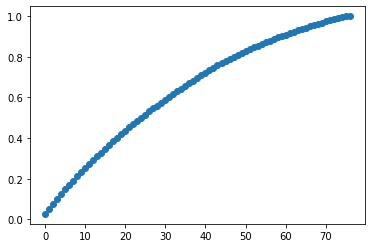

In [15]:
#plota a importância das variáveis
sum_importances = sum_and_plot_importances(variables, importances)

In [16]:
sum_importances

,0,1
0,Item 2,0.026462
1,Item 8,0.051598
2,Item 7,0.076039
3,Item 1,0.100278
4,Item 6,0.124498
...,...,...
72,Item 54,0.986108
73,Item 48,0.991031
74,Item 51,0.995836
75,Item 50,0.999967


# Dividindo os dados do dataset para treino e teste

In [17]:
#cria a função para divisão
def split_datasets(historic, target, test_size=0.2):
  X_train, X_test, y_train, y_test = train_test_split(historic, target,
                                                      test_size=test_size, stratify=target,
                                                      random_state=0)
  y_train, y_test = np.array(y_train).ravel(), np.array(y_test).ravel()
  return X_train, X_test, y_train, y_test

In [18]:
#faz a divisão
X_train, X_test, y_train, y_test = split_datasets(historic, target)
X_train.shape

(31254, 77)

# Modelagem Preliminar

In [22]:
#faz a função para mostrar AUC e ROC
def rfc_test(X_train, y_train, n_estimators, cv):
  np.random.seed(0)
  rfc = RandomForestClassifier(n_estimators=n_estimators, random_state=0, n_jobs=-1)
  cv_scores = cross_val_score(rfc, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
  print('Média dos {} testes: '.format(cv), cv_scores.mean())
  return rfc

In [23]:
#gera o modelo
model = rfc_test(X_train, y_train, cv=20, n_estimators=300)

Média dos 20 testes:  0.9873734609244144


In [24]:
#gera o modelo
#model = RandomForestRegressor(n_estimators=300, random_state=0)
#fit modelo
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [25]:
#faz predição com dados de validacao
valoresPrevistos = model.predict(X_test)

#resultado entre 1 e 2, com decimais

In [26]:
valoresPrevistos

array([1, 1, 2, ..., 2, 2, 2])

In [27]:
y_test

array([1, 1, 2, ..., 2, 2, 2])

In [28]:
#lista comparação dos primeiros 50 registros
margemAceitavel = 0.3
for i in range(0, 50):
  if abs(valoresPrevistos[i] - y_test[i]) > margemAceitavel:
    print("Valor previsto: {:.2f} x Valor Real: {}".format(valoresPrevistos[i], y_test[i]), end=' ')
    print(" <<<--- falha: diferença de {:.2f}".format(valoresPrevistos[i] - y_test[i]))
  else:
    print("Valor previsto: {:.2f} x Valor Real: {}".format(valoresPrevistos[i], y_test[i]))


Valor previsto: 1.00 x Valor Real: 1
Valor previsto: 1.00 x Valor Real: 1
Valor previsto: 2.00 x Valor Real: 2
Valor previsto: 2.00 x Valor Real: 2
Valor previsto: 2.00 x Valor Real: 2
Valor previsto: 2.00 x Valor Real: 2
Valor previsto: 2.00 x Valor Real: 2
Valor previsto: 1.00 x Valor Real: 1
Valor previsto: 2.00 x Valor Real: 2
Valor previsto: 1.00 x Valor Real: 1
Valor previsto: 2.00 x Valor Real: 1  <<<--- falha: diferença de 1.00
Valor previsto: 2.00 x Valor Real: 2
Valor previsto: 2.00 x Valor Real: 2
Valor previsto: 2.00 x Valor Real: 2
Valor previsto: 1.00 x Valor Real: 1
Valor previsto: 2.00 x Valor Real: 2
Valor previsto: 2.00 x Valor Real: 2
Valor previsto: 2.00 x Valor Real: 2
Valor previsto: 2.00 x Valor Real: 2
Valor previsto: 2.00 x Valor Real: 2
Valor previsto: 2.00 x Valor Real: 2
Valor previsto: 2.00 x Valor Real: 1  <<<--- falha: diferença de 1.00
Valor previsto: 1.00 x Valor Real: 1
Valor previsto: 1.00 x Valor Real: 1
Valor previsto: 2.00 x Valor Real: 2
Valor pre

In [29]:
#lista quantidade de acertos (considerando um percentual de dúvida)
contaOk = 0
contaNao = 0
for i in range(0, len(y_test)):
  if abs(valoresPrevistos[i] - y_test[i]) < margemAceitavel:
    contaOk += 1
  else:
    contaNao += 1

print("Quantidade de resultados OK: {}\nQuantidade de resultados Não: {}".format(contaOk, contaNao))
print("Percentual de acertos: {:.2f}%".format(contaOk/len(y_test)))

Quantidade de resultados OK: 7473
Quantidade de resultados Não: 341
Percentual de acertos: 0.96%
